In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape to (batch_size, 28, 28, 1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


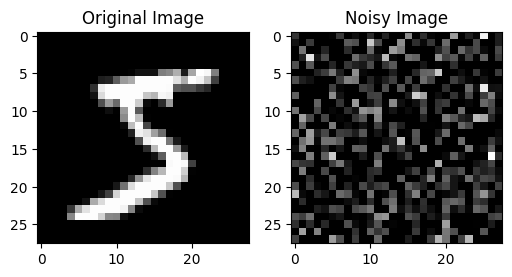

In [2]:
image = x_train[0] / 255.0  # Normalize to 0-1 range

# Add Gaussian Noise
noise_factor = 0.3    # This is the scale which tell that how much noise shoulld be added , more the number more the noise added .
noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
noisy_image = np.clip(noisy_image, 0.0, 1.0)  # Keep values between 0 and 1

# Fix: Reshape image to 28x28
image = image.reshape(28, 28)
noisy_image = noisy_image.reshape(28, 28)

# Plot Original vs Noisy Image
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")

plt.subplot(1,2,2)
plt.title("Noisy Image")
plt.imshow(noisy_image, cmap="gray")

plt.show()

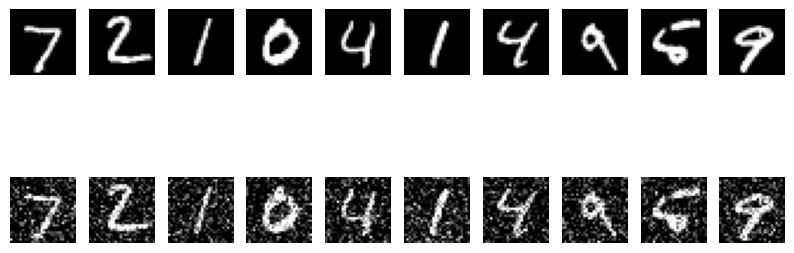

In [3]:
def add_noise(images, noise_factor=0.3):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # Ensure pixel values are between 0 and 1
    return noisy_images

# Add noise to training and test datasets
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Visualize noisy images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis('off')

    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.show()


In [4]:
# Build the Denoising Autoencoder model
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

# Output layer (same as input)
output_img = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = models.Model(input_img, output_img)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the model
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the autoencoder
history = autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=256, validation_data=(x_test_noisy, x_test))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - loss: 0.1598 - val_loss: 0.0946
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - loss: 0.0913 - val_loss: 0.0879
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - loss: 0.0866 - val_loss: 0.0843
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - loss: 0.0842 - val_loss: 0.0826
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - loss: 0.0828 - val_loss: 0.0817
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 348ms/step - loss: 0.0818 - val_loss: 0.0806
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - loss: 0.0809 - val_loss: 0.0800
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 132ms/step - loss: 0.0803 - val_loss: 0.0796
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - loss: 0.0798 - val_loss: 0.0789
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - loss: 0.0794 - val_loss: 0.0786


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


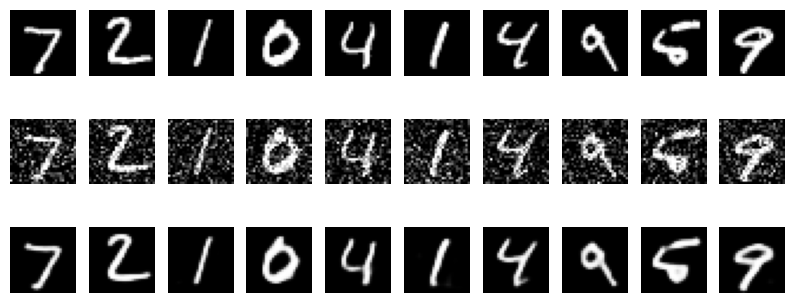

In [6]:
# Evaluate the model on test data
decoded_images = autoencoder.predict(x_test_noisy)

# Visualize the original, noisy, and denoised images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis('off')

    plt.subplot(3, 10, i+11)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.axis('off')

    plt.subplot(3, 10, i+21)
    plt.imshow(decoded_images[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.show()